<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [50]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
#Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [3]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

# user imports
import data_processing.analysis_utils as ls_utils

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Display Constants

In [4]:
agg_cols_change = ['active_apps_agg_change',
 'passive_apps_agg_change',
 'social_apps_agg_change',
 'work_dur_agg_change',
 'home_dur_agg_change',
 'religion_dur_agg_change',
 'exercise_dur_agg_change',                   
 'shopping_dur_agg_change',
 'other_dur_agg_change',
 'social_dur_agg_change',
 'sms_agg_change',
 'cal_agg_change',
 'movt_agg_change',
 'wkday_total_entropy_agg_change',
 'wkend_entropy_agg_change']
sel_agg_cols = [x for x in agg_cols_change if 'fga' not in x]
groups = ['all', 'no_symp', 'soc_anx', 'gen_anx', 'dep_anx']

# Load Data

In [5]:
gad_spin_corr = pd.read_pickle("wave1_features/all_gad_spin_corr_unit.df")
rev_gad_spin_corr = pd.read_pickle("wave1_features/all_rev_gad_spin_corr_unit.df")

phq_corr = pd.read_pickle("wave1_features/all_phq_corr_unit.df")
rev_phq_corr = pd.read_pickle("wave1_features/all_rev_phq_corr_unit.df")

In [6]:
rev_gad_spin_corr['gad_diff'] = rev_gad_spin_corr['gad_diff'].astype(float)

# Plots over time

## PHQ

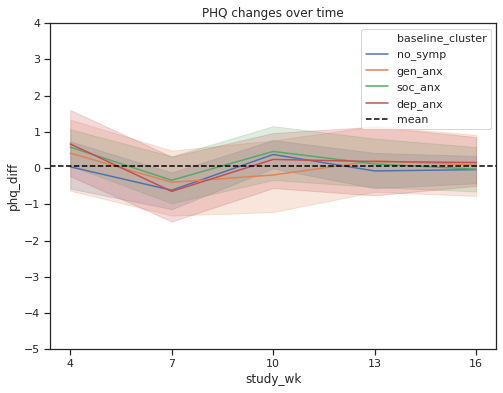

In [45]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=phq_corr, ax=ax)
plt.xticks([4, 7,10,13,16])
plt.axhline(phq_corr['phq_diff'].mean(), ls='--', color='black', label='mean')
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("PHQ changes over time")
plt.show()

## GAD

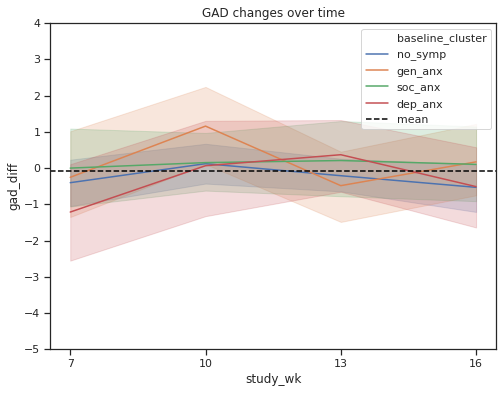

In [47]:
gad_spin_corr['gad_diff'] = gad_spin_corr['gad_diff'].astype(float)
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.axhline(gad_spin_corr['gad_diff'].mean(), ls='--', color='black', label='mean')
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

## SPIN

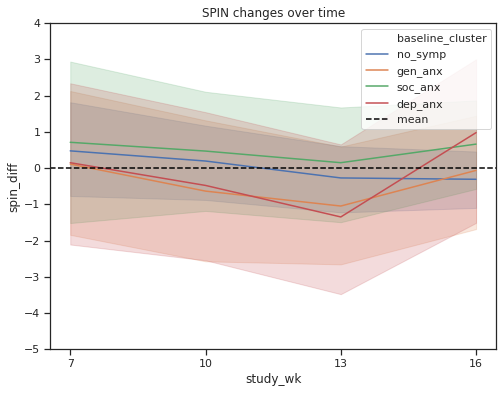

In [48]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.axhline(gad_spin_corr['spin_diff'].mean(), ls='--', color='black', label='mean')
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

# Time-based regression

In [8]:
from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

In [35]:
phq_reg_df = phq_corr.copy()
phq_reg_df = phq_reg_df[~phq_reg_df['phq_diff'].isna()]

In [36]:
gad_spin_reg_df = gad_spin_corr.copy()
gad_reg_df = gad_spin_reg_df[~gad_spin_reg_df['gad_diff'].isna()]
gad_reg_df['gad_diff'] = gad_reg_df['gad_diff'].astype(float)
spin_reg_df = gad_spin_reg_df[~gad_spin_reg_df['spin_diff'].isna()]
gad_reg_df['spin_diff'] = gad_reg_df['spin_diff'].astype(float)
#gad_spin_reg_df = gad_spin_reg_df.set_index(['pid'])
#gad_spin_reg_df = gad_spin_reg_df.set_index(['pid', 'survey_idx'])

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## PHQ differences against time

### Study week as categorical

In [37]:
formula = """phq_diff ~1 + C(study_wk)"""
mod = smf.ols(formula, data=phq_reg_df)
res = mod.fit(cov_type='cluster', cov_kwds={'groups' : phq_reg_df['pid']})
res.summary()
#formula = """phq_diff ~ 1 + survey_idx + EntityEfregcts """
#model = PanelOLS.from_formula(formula, data=phq_reg_df)
#print(model.fit(cov_type='robust'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               phq_diff   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.293
Date:                Mon, 13 Apr 2020   Prob (F-statistic):             0.0598
Time:                        16:30:46   Log-Likelihood:                -3423.0
No. Observations:                1360   AIC:                             6856.
Df Residuals:                    1355   BIC:                             6882.
Df Model:                           4                                         
Covariance Type:              cluster                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3838      0.192      2.000      0.045       0.008       0.760
C(study_wk)[T.7]     -0.8771      0.303     -2.898      0.004      -1.470      -0.284
C(study_wk)[T.10]    -0.1474      0.274     -0.539      0.590      -0.684       0.389
C(study_wk)[T.13]    -0.2970      0.272     -1.091      0.275      -0.830       0.236
C(study_wk)[T.16]    -0.3559      0.259     -1.372      0.170      -0.864       0.152
==============================================================================
Omnibus:                      131.620   Durbin-Watson:                   2.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              909.749
Skew:                           0.051   Prob(JB):                    2.82e-198
Kurtosis:                       7.006   Cond. No.                         5.83
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

### Study week as continuous

In [38]:
formula = """phq_diff ~ 1 + study_wk"""
mod = smf.ols(formula, data=phq_reg_df)
res = mod.fit(cov_type='cluster', cov_kwds={'groups' : phq_reg_df['pid']})
res.summary()
#formula = """phq_diff ~ 1 + survey_idx + EntityEfregcts """
#model = PanelOLS.from_formula(formula, data=phq_reg_df)
#print(model.fit(cov_type='robust'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               phq_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06716
Date:                Mon, 13 Apr 2020   Prob (F-statistic):              0.796
Time:                        16:30:48   Log-Likelihood:                -3429.7
No. Observations:                1360   AIC:                             6863.
Df Residuals:                    1358   BIC:                             6874.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0922      0.185      0.498      0.618      -0.271       0.455
study_wk      -0.0044      0.017     -0.259      0.796      -0.038       0.029
==============================================================================
Omnibus:                      132.881   Durbin-Watson:                   2.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              931.998
Skew:                           0.046   Prob(JB):                    4.16e-203
Kurtosis:                       7.054   Cond. No.                         28.0
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## GAD differences against time

### Study week as categorical

In [39]:
formula = """gad_diff ~1 + C(study_wk)"""
mod = smf.ols(formula, data=gad_reg_df)
res = mod.fit(cov_type='cluster', cov_kwds={'groups' : gad_reg_df['pid']})
res.summary()
#formula = """gad_diff ~ 1 + survey_idx + EntityEfregcts """
#model = PanelOLS.from_formula(formula, data=gad_reg_df)
#print(model.fit(cov_type='robust'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               gad_diff   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.452
Date:                Mon, 13 Apr 2020   Prob (F-statistic):              0.228
Time:                        16:30:50   Log-Likelihood:                -2845.3
No. Observations:                1033   AIC:                             5699.
Df Residuals:                    1029   BIC:                             5718.
Df Model:                           3                                         
Covariance Type:              cluster                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4109      0.255     -1.609      0.108      -0.911       0.090
C(study_wk)[T.10]     0.7844      0.397      1.977      0.048       0.007       1.562
C(study_wk)[T.13]     0.3450      0.352      0.981      0.327      -0.344       1.034
C(study_wk)[T.16]     0.2224      0.360      0.618      0.536      -0.482       0.927
==============================================================================
Omnibus:                       43.375   Durbin-Watson:                   2.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.369
Skew:                           0.012   Prob(JB):                     1.33e-28
Kurtosis:                       4.727   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

### Study week as continuous

In [40]:
formula = """gad_diff ~ 1 + study_wk"""
mod = smf.ols(formula, data=gad_reg_df)
res = mod.fit(cov_type='cluster', cov_kwds={'groups' : gad_reg_df['pid']})
res.summary()
#formula = """gad_diff ~ 1 + survey_idx + EntityEfregcts """
#model = PanelOLS.from_formula(formula, data=gad_reg_df)
#print(model.fit(cov_type='robust'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               gad_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.04597
Date:                Mon, 13 Apr 2020   Prob (F-statistic):              0.830
Time:                        16:30:58   Log-Likelihood:                -2848.2
No. Observations:                1033   AIC:                             5700.
Df Residuals:                    1031   BIC:                             5710.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1603      0.418     -0.384      0.701      -0.979       0.659
study_wk       0.0075      0.035      0.214      0.830      -0.061       0.076
==============================================================================
Omnibus:                       45.130   Durbin-Watson:                   2.502
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.541
Skew:                          -0.004   Prob(JB):                     1.36e-30
Kurtosis:                       4.788   Cond. No.                         43.1
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## SPIN differences against time

### Study week as categorical

In [41]:
formula = """spin_diff ~1 + C(study_wk)"""
mod = smf.ols(formula, data=spin_reg_df)
res = mod.fit(cov_type='cluster', cov_kwds={'groups' : spin_reg_df['pid']})
res.summary()
#formula = """spin_diff ~ 1 + survey_idx + EntityEfregcts """
#model = PanelOLS.from_formula(formula, data=spin_reg_df)
#print(model.fit(cov_type='robust'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              spin_diff   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8349
Date:                Mon, 13 Apr 2020   Prob (F-statistic):              0.476
Time:                        16:32:31   Log-Likelihood:                -3414.3
No. Observations:                1032   AIC:                             6837.
Df Residuals:                    1028   BIC:                             6856.
Df Model:                           3                                         
Covariance Type:              cluster                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3876      0.487      0.796      0.426      -0.567       1.342
C(study_wk)[T.10]    -0.4460      0.764     -0.583      0.560      -1.944       1.052
C(study_wk)[T.13]    -0.9341      0.620     -1.506      0.132      -2.150       0.282
C(study_wk)[T.16]    -0.1482      0.597     -0.248      0.804      -1.319       1.023
==============================================================================
Omnibus:                      104.910   Durbin-Watson:                   2.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              714.880
Skew:                          -0.120   Prob(JB):                    5.83e-156
Kurtosis:                       7.070   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

### Study week as continuous

In [42]:
formula = """spin_diff ~ 1 + study_wk"""
mod = smf.ols(formula, data=spin_reg_df)
res = mod.fit(cov_type='cluster', cov_kwds={'groups' : spin_reg_df['pid']})
res.summary()
#formula = """spin_diff ~ 1 + survey_idx + EntityEfregcts """
#model = PanelOLS.from_formula(formula, data=spin_reg_df)
#print(model.fit(cov_type='robust'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              spin_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3236
Date:                Mon, 13 Apr 2020   Prob (F-statistic):              0.570
Time:                        16:32:31   Log-Likelihood:                -3415.7
No. Observations:                1032   AIC:                             6835.
Df Residuals:                    1030   BIC:                             6845.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3621      0.682      0.531      0.595      -0.974       1.698
study_wk      -0.0310      0.054     -0.569      0.569      -0.138       0.076
==============================================================================
Omnibus:                      105.401   Durbin-Watson:                   2.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.694
Skew:                          -0.115   Prob(JB):                    2.62e-158
Kurtosis:                       7.102   Cond. No.                         43.1
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

# Baseline Clustering

In [194]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")

train_cluster = pd.read_pickle("ls_data/train_cluster.df")
test_cluster = pd.read_pickle("ls_data/test_cluster.df")
all_cluster = train_cluster.append(test_cluster).to_frame()

In [195]:
phq_baseline = phq_df[phq_df['redcap_event_name'] == 'week_0_arm_1']
phq_baseline = phq_baseline.drop(['phq_total_sc', 'phq_start', 'redcap_event_name'], axis=1)

In [196]:
baseline_df = state_df[state_df['redcap_event_name'] == 'week_0_arm_1']
baseline_df = baseline_df.loc[:, ~baseline_df.columns.str.startswith('psqi')]
baseline_df = baseline_df.loc[:, ~baseline_df.columns.str.startswith('shaps')]
baseline_df = baseline_df.loc[:, ~baseline_df.columns.str.endswith('start')]
baseline_df = baseline_df.loc[:, ~baseline_df.columns.str.contains('txhx')]
baseline_df = baseline_df.drop(['redcap_event_name'], axis=1)
psqi_comp_cols = ['psqi_durat', 'psqi_distb', 'psqi_laten', 'psqi_daydys', #'psqi_hse', 
                  'psqi_slpqual', 'psqi_meds']

#baseline_df = baseline_df.merge(baseline_redcap_df[['pid'] + psqi_comp_cols], on='pid', how='left')
baseline_df = baseline_df.merge(phq_baseline, on='pid', how='left')
baseline_df = baseline_df.replace(to_replace=[99,999], value=np.nan)

# remap response 4 of gad08 to correct order
baseline_df['gad08'] = baseline_df['gad08'].replace(4,0)

In [197]:
color_dict = {
    0: "b",
    1: "g",
    2: "y",
    3: "r"
}

In [158]:
cluster_df = all_cluster.merge(baseline_df, on='pid', how='left')
cluster_df = cluster_df.set_index('pid')
cluster_df = cluster_df.sort_values(by='cluster')

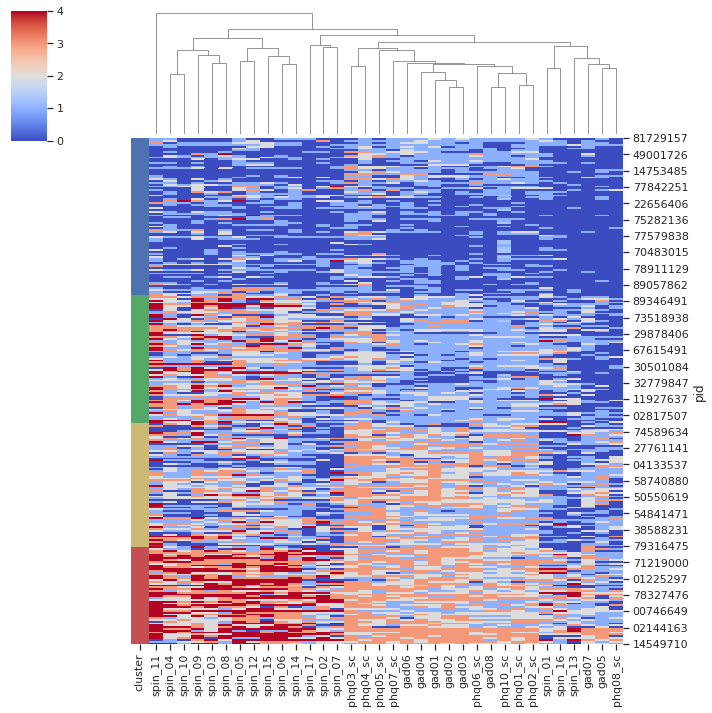

In [140]:
cluster_df = cluster_df.fillna(cluster_df.mean())
row_colors = cluster_df['cluster'].map(color_dict)
clustergrid = sns.clustermap(cluster_df.drop(['cluster'], axis=1), 
               row_colors=row_colors, 
               #z_score=1,
               row_cluster=False,
               cmap='coolwarm',
               xticklabels=True)
reordered_col_ind = clustergrid.dendrogram_col.reordered_ind
reordered_col = [list(cluster_df.drop(['cluster'], axis=1))[i] for i in reordered_col_ind]

In [141]:
cluster_corr = pd.concat([cluster_df,pd.get_dummies(cluster_df['cluster'], prefix="cluster")], axis=1)

In [142]:
question_cols = cluster_corr.columns[(cluster_corr.columns.str.startswith('phq')) | 
                                     (cluster_corr.columns.str.startswith('gad')) |
                                     (cluster_corr.columns.str.startswith('spin'))].values.tolist()

## Cluster 0: "no symptom"

In [143]:
pg.pairwise_corr(cluster_corr,columns=[question_cols, ['cluster_0']], padjust='fdr_bh').sort_values(by='adj_r2', ascending=False)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power
13,spin_06,cluster_0,pearson,two-sided,282,-0.636,"[-0.7, -0.56]",0.405,0.401,-0.751,2.046387e-33,6.957716e-32,fdr_bh,1.625e+30,1.0
1,gad02,cluster_0,pearson,two-sided,282,-0.618,"[-0.69, -0.54]",0.382,0.377,-0.722,4.352906e-31,7.399939e-30,fdr_bh,8.167e+27,1.0
2,gad03,cluster_0,pearson,two-sided,282,-0.589,"[-0.66, -0.51]",0.347,0.343,-0.676,9.297599e-28,1.053728e-26,fdr_bh,4.228e+24,1.0
10,spin_03,cluster_0,pearson,two-sided,282,-0.580,"[-0.65, -0.5]",0.337,0.332,-0.662,8.719788e-27,7.411820e-26,fdr_bh,4.648e+23,1.0
21,spin_14,cluster_0,pearson,two-sided,282,-0.576,"[-0.65, -0.49]",0.331,0.326,-0.656,2.848848e-26,1.937216e-25,fdr_bh,1.446e+23,1.0
22,spin_15,cluster_0,pearson,two-sided,282,-0.557,"[-0.63, -0.47]",0.311,0.306,-0.628,2.081659e-24,1.179607e-23,fdr_bh,2.105e+21,1.0
0,gad01,cluster_0,pearson,two-sided,282,-0.551,"[-0.63, -0.46]",0.303,0.298,-0.620,9.080681e-24,4.410616e-23,fdr_bh,4.933e+20,1.0
7,gad08,cluster_0,pearson,two-sided,282,-0.550,"[-0.63, -0.46]",0.302,0.297,-0.618,1.146634e-23,4.873196e-23,fdr_bh,3.92e+20,1.0
25,phq01_sc,cluster_0,pearson,two-sided,282,-0.547,"[-0.62, -0.46]",0.299,0.294,-0.614,2.020430e-23,7.632737e-23,fdr_bh,2.244e+20,1.0
11,spin_04,cluster_0,pearson,two-sided,282,-0.546,"[-0.62, -0.46]",0.298,0.293,-0.613,2.810068e-23,9.554232e-23,fdr_bh,1.621e+20,1.0


## Cluster 1: "social anxiety"

In [144]:
pg.pairwise_corr(cluster_corr,columns=[question_cols, ['cluster_1']], padjust='fdr_bh').sort_values(by='adj_r2', ascending=False)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power
16,spin_09,cluster_1,pearson,two-sided,282,0.293,"[0.18, 0.4]",0.086,0.079,0.302,5.487993e-07,0.000019,fdr_bh,1.953e+04,0.999
11,spin_04,cluster_1,pearson,two-sided,282,0.256,"[0.14, 0.36]",0.066,0.059,0.262,1.310222e-05,0.000223,fdr_bh,945.483,0.992
10,spin_03,cluster_1,pearson,two-sided,282,0.240,"[0.13, 0.35]",0.058,0.051,0.245,4.529680e-05,0.000513,fdr_bh,292.323,0.984
18,spin_11,cluster_1,pearson,two-sided,282,0.226,"[0.11, 0.33]",0.051,0.044,0.230,1.329392e-04,0.001130,fdr_bh,106.202,0.970
3,gad04,cluster_1,pearson,two-sided,282,-0.216,"[-0.32, -0.1]",0.047,0.040,-0.219,2.588135e-04,0.001760,fdr_bh,56.963,0.956
13,spin_06,cluster_1,pearson,two-sided,282,0.206,"[0.09, 0.32]",0.043,0.036,0.209,4.921168e-04,0.002789,fdr_bh,31.332,0.938
15,spin_08,cluster_1,pearson,two-sided,282,0.197,"[0.08, 0.31]",0.039,0.032,0.200,8.650804e-04,0.004202,fdr_bh,18.594,0.917
2,gad03,cluster_1,pearson,two-sided,282,-0.195,"[-0.3, -0.08]",0.038,0.031,-0.198,1.019580e-03,0.004279,fdr_bh,15.981,0.910
22,spin_15,cluster_1,pearson,two-sided,282,0.193,"[0.08, 0.3]",0.037,0.030,0.195,1.132718e-03,0.004279,fdr_bh,14.506,0.905
0,gad01,cluster_1,pearson,two-sided,282,-0.190,"[-0.3, -0.08]",0.036,0.029,-0.192,1.311871e-03,0.004460,fdr_bh,12.675,0.897


## Cluster 2: "anxiety and depression"

In [145]:
pg.pairwise_corr(cluster_corr,columns=[question_cols, ['cluster_2']], padjust='fdr_bh').sort_values(by='adj_r2', ascending=False)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power
3,gad04,cluster_2,pearson,two-sided,282,0.398,"[0.29, 0.49]",0.158,0.152,0.421,4.011244e-12,1.363823e-10,fdr_bh,1.846e+09,1.000
0,gad01,cluster_2,pearson,two-sided,282,0.380,"[0.28, 0.48]",0.145,0.139,0.400,3.877050e-11,6.590985e-10,fdr_bh,2.024e+08,1.000
2,gad03,cluster_2,pearson,two-sided,282,0.369,"[0.26, 0.47]",0.136,0.130,0.387,1.608335e-10,1.822779e-09,fdr_bh,5.074e+07,1.000
31,phq07_sc,cluster_2,pearson,two-sided,282,0.333,"[0.22, 0.43]",0.111,0.104,0.346,1.024954e-08,8.712109e-08,fdr_bh,9.035e+05,1.000
25,phq01_sc,cluster_2,pearson,two-sided,282,0.329,"[0.22, 0.43]",0.108,0.102,0.342,1.595951e-08,1.085247e-07,fdr_bh,5.89e+05,1.000
4,gad05,cluster_2,pearson,two-sided,282,0.326,"[0.22, 0.43]",0.106,0.100,0.338,2.081006e-08,1.179237e-07,fdr_bh,4.558e+05,1.000
5,gad06,cluster_2,pearson,two-sided,282,0.321,"[0.21, 0.42]",0.103,0.096,0.333,3.611622e-08,1.754216e-07,fdr_bh,2.677e+05,1.000
7,gad08,cluster_2,pearson,two-sided,282,0.304,"[0.19, 0.41]",0.092,0.086,0.314,1.939811e-07,8.244195e-07,fdr_bh,5.303e+04,1.000
1,gad02,cluster_2,pearson,two-sided,282,0.297,"[0.19, 0.4]",0.088,0.082,0.306,3.815732e-07,1.297349e-06,fdr_bh,2.768e+04,0.999
28,phq04_sc,cluster_2,pearson,two-sided,282,0.298,"[0.19, 0.4]",0.089,0.082,0.307,3.537283e-07,1.297349e-06,fdr_bh,2.977e+04,0.999


## Cluster 3: "multiple comorbidities"

In [146]:
pg.pairwise_corr(cluster_corr,columns=[question_cols, ['cluster_3']], padjust='fdr_bh').sort_values(by='adj_r2', ascending=False)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power
21,spin_14,cluster_3,pearson,two-sided,282,0.606,"[0.53, 0.68]",0.368,0.363,0.703,1.034138e-29,3.516068e-28,fdr_bh,3.581e+26,1.000
13,spin_06,cluster_3,pearson,two-sided,282,0.582,"[0.5, 0.65]",0.339,0.334,0.665,6.064025e-27,1.030884e-25,fdr_bh,6.651e+23,1.000
17,spin_10,cluster_3,pearson,two-sided,282,0.560,"[0.47, 0.64]",0.314,0.309,0.633,1.127530e-24,1.277867e-23,fdr_bh,3.852e+21,1.000
23,spin_16,cluster_3,pearson,two-sided,282,0.543,"[0.46, 0.62]",0.295,0.290,0.608,4.830590e-23,4.106002e-22,fdr_bh,9.511e+19,1.000
9,spin_02,cluster_3,pearson,two-sided,282,0.538,"[0.45, 0.62]",0.289,0.284,0.601,1.512015e-22,1.028170e-21,fdr_bh,3.092e+19,1.000
19,spin_12,cluster_3,pearson,two-sided,282,0.529,"[0.44, 0.61]",0.280,0.275,0.589,9.725508e-22,5.511121e-21,fdr_bh,4.95e+18,1.000
1,gad02,cluster_3,pearson,two-sided,282,0.526,"[0.44, 0.61]",0.277,0.271,0.585,1.856061e-21,9.015151e-21,fdr_bh,2.621e+18,1.000
20,spin_13,cluster_3,pearson,two-sided,282,0.524,"[0.43, 0.6]",0.274,0.269,0.582,2.884741e-21,1.226015e-20,fdr_bh,1.698e+18,1.000
10,spin_03,cluster_3,pearson,two-sided,282,0.520,"[0.43, 0.6]",0.271,0.266,0.576,5.769202e-21,2.179476e-20,fdr_bh,8.587e+17,1.000
2,gad03,cluster_3,pearson,two-sided,282,0.506,"[0.41, 0.59]",0.256,0.250,0.557,1.064943e-19,3.620806e-19,fdr_bh,4.883e+16,1.000


# Final symptom groupings

In [198]:
cluster_df = all_cluster.merge(baseline_df, on='pid', how='left')
cluster_df = cluster_df.sort_values(by='cluster')
cluster_df.drop('phq10_sc', axis='columns', inplace=True)

cluster_df['spin_tot'] = cluster_df.loc[:, cluster_df.columns.str.startswith("spin")].sum(axis=1)
cluster_df['phq_tot'] = cluster_df.loc[:, cluster_df.columns.str.startswith("phq")].sum(axis=1)
cluster_df['gad_tot'] = cluster_df.loc[:, cluster_df.columns.str.startswith("gad")].sum(axis=1)

In [199]:
no_mild = cluster_df[(cluster_df['spin_tot'] < 31) & (cluster_df['gad_tot'] < 10) & (cluster_df['phq_tot'] < 10)]
no_mild_pids = no_mild['pid']
no_mild_pids.to_pickle("ls_data/jama_data/no_mild_pids.df")

In [202]:
symptom = cluster_df[(cluster_df['spin_tot'] >= 31) | (cluster_df['gad_tot'] >= 10) | (cluster_df['phq_tot'] >= 10)]
symptom_pids = symptom['pid']
symptom_pids.to_pickle("ls_data/jama_data/symptom_pids.df")

## Build correlation analysis dfs

In [217]:
gad_spin_corr = pd.read_pickle("wave1_features/all_gad_spin_corr_unit.df")
rev_gad_spin_corr = pd.read_pickle("wave1_features/all_rev_gad_spin_corr_unit.df")

phq_corr = pd.read_pickle("wave1_features/all_phq_corr_unit.df")
rev_phq_corr = pd.read_pickle("wave1_features/all_rev_phq_corr_unit.df")


gad_spin_gps = pd.read_pickle("wave1_features/all_gad_spin_gps_corr.df")
rev_gad_spin_gps = pd.read_pickle("wave1_features/all_rev_gad_spin_gps_corr.df")

phq_gps = pd.read_pickle("wave1_features/all_phq_gps_corr.df")
rev_phq_gps = pd.read_pickle("wave1_features/all_rev_phq_gps_corr.df")

In [218]:
drop_cols = [ "movt_agg_change", "wkday_total_entropy_agg_change", "wkend_entropy_agg_change"]
gad_spin_corr.drop(drop_cols, axis='columns', inplace=True)
rev_gad_spin_corr.drop(drop_cols, axis='columns', inplace=True)

phq_corr.drop(drop_cols, axis='columns', inplace=True)
rev_phq_corr.drop(drop_cols, axis='columns', inplace=True)

In [219]:
gps_cols = ['pid', 'study_wk'] + list(phq_corr_gps.columns[phq_corr_gps.columns.str.endswith("agg_change")])

In [222]:
gad_spin_all = gad_spin_corr.merge(gad_spin_gps[gps_cols], on=['pid', 'study_wk'], how='left')
rev_gad_spin_all = rev_gad_spin_corr.merge(rev_gad_spin_gps[gps_cols], on=['pid', 'study_wk'], how='left')

phq_all = phq_corr.merge(phq_gps[gps_cols], on=['pid', 'study_wk'], how='left')
rev_phq_all = rev_phq_corr.merge(rev_phq_gps[gps_cols], on=['pid', 'study_wk'], how='left')

In [228]:
group_dict = {
    0: "no/mild",
    1: "symptomatic"
}

gad_spin_all['group'] = gad_spin_all['pid'].isin(symptom_pids).astype(int)
gad_spin_all['group_label'] = gad_spin_all['group'].map(group_dict)
rev_gad_spin_all['group'] = rev_gad_spin_all['pid'].isin(symptom_pids).astype(int)
rev_gad_spin_all['group_label'] = rev_gad_spin_all['group'].map(group_dict)

phq_all['group'] = phq_all['pid'].isin(symptom_pids).astype(int)
phq_all['group_label'] = phq_all['group'].map(group_dict)
rev_phq_all['group'] = rev_phq_all['pid'].isin(symptom_pids).astype(int)
rev_phq_all['group_label'] = rev_phq_all['group'].map(group_dict)

In [230]:
gad_spin_all.to_pickle("ls_data/jama_data/gad_spin_2grp.df")
rev_gad_spin_all.to_pickle("ls_data/jama_data/rev_gad_spin_2grp.df")

phq_all.to_pickle("ls_data/jama_data/phq_2grp.df")
rev_phq_all.to_pickle("ls_data/jama_data/rev_phq_2grp.df")